# Contents <a id='top'></a>

1. <a href=#exploration>CDNOW Dataset</a>
    1. <a href=#exploration>Exploration</a>
    1. <a href=#rfm>RFM Modeling<a>
    1. <a href=#hclust>Hierarchical Clustering</a>
1. <a href=#mba>Market Basket Analysis</a>
1. <a href=#ref>References and Summary</a>
---

<a id='exploration'></a>
## CDNOW Dataset 

### Exploration
<a href=#top>(back to top)</a>

CDNOW is a company that sold CDs online. It was started in 1994, but it closed after the dot-com bust of the late 90s. The dataset that we have comes from the transactions made by a **single cohort** of customers at this online store. The single cohort of customers is defined by customers who made their first purchase within the first 12 weeks of 1997. These customers are then tracked until June 30th 1998. Each row in our dataset consists of the customer id, week of purchase, quantity of CDs purchased and the amount spent in that week. There are 23,570 customers in this cohort and 64,258 transactions in this dataset. Let's read in the dataset first.

In [2]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.cluster import hierarchy

from myscripts import clust

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
cdnow2 = pd.read_csv('../data/CDNOW2.csv')

In [23]:
cdnow2.head(n=10)

,cid,week_num,qty,amnt
0,1,1,1,11.77
1,2,2,6,89.00
2,3,1,2,20.76
3,3,13,2,20.76
4,3,14,2,19.54
5,3,46,5,57.45
6,3,47,4,20.96
7,3,74,1,16.99
8,4,1,2,29.33
9,4,3,2,29.73


In [24]:
cdnow2[['qty', 'amnt']].describe(percentiles=[0.8, 0.9, 0.99]).round(2)

,qty,amnt
count,64258.00,64258.00
mean,2.61,38.91
std,2.83,43.99
min,1.00,0.00
50%,2.00,27.48
80%,4.00,54.22
90%,5.00,77.65
99%,13.00,199.99
max,162.00,3029.92


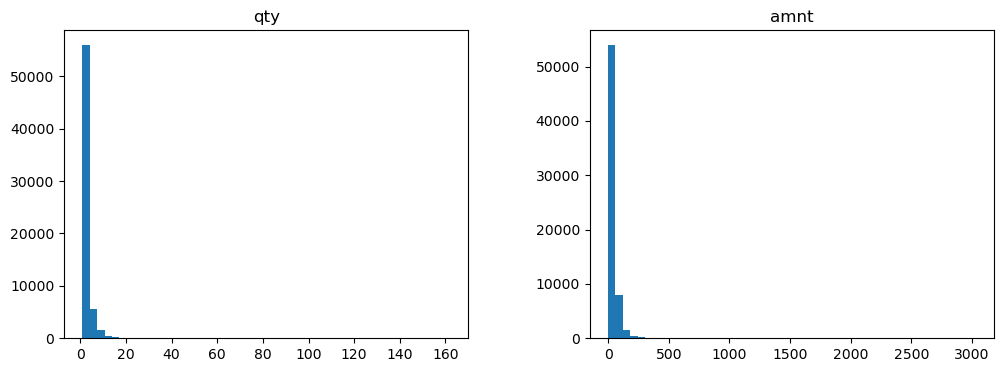

In [25]:
cdnow2[['qty', 'amnt']].hist(figsize=(12,4), grid=False, bins=50);

The median amount spent in a weekly transaction is approximately 27 dollars. This is a very right-skewed distribution. The quantity of CDs bought has a median of 2 per week, but this is also an extremely right-skewed distribution.

---

<a id='rfm'></a>
### RFM Modeling
<a href=#top>(back to top)</a>

RFM tells you how customers behaved in the past:
  * **Recency**: When was the last time they bought something?
  * **Frequency**: How frequently do they buy things?
  * **Monetary**: How much have they spent?
  
The ideas behind it are these assumptions:
1. Recent customers are more likely to buy than customers who haven't purchased in a while.
2. Customers who purchase often are more likely to buy than those who don't purchased often.
3. Customers who spend more are more likely to buy again than those who spend less.

The purpose of RFM modeling is to yield insights pertaining to:
* the best/most valuable customers.
* the right time to "nudge" or "remind" a customer via an offer.
* identifying customers for whom it might be fruitful to try an upsell strategy.

Here's how RFM works: For each customer, we compute the time since their most recent purchase ($r$), the number of visits or purchases made ($f$) and the amount spent per visit or the total amount spent ($m$). Next, we divide each category into five equal groups and assign a score (from 1 to 5) for each customer within that category. Higher scores correspond to more recent, more frequent and more valuable customers.

Suppose that the original customers made the following transactions:

<img src="../figs/how_does_rfm_work_1.png" style="width: 600px;"/>

Then after the division into groups, the RFM scores would be:

<img src="../figs/how_does_rfm_work_2.png" style="width: 600px;"/>

Sometimes, if appropriate, a business may divide up their history into periods, and study how customers' RFM scores have changed. In such a scenario, if a customer changes from 555 to 125, it may be an indication that a customer is about to churn. It would be worth a try to offer him or her a retention package. On the other hand, if a customer changes from 531 to 555, the customer has the potential to be a loyal one. It is worthwhile to send them a note or a discount voucher to reward them.

In [26]:
cdgrouped = cdnow2.groupby('cid')

cd2 = cdgrouped.agg({'amnt': np.sum, 'cid': len, 'week_num': np.max})

In [27]:
cd2

,amnt,cid,week_num
cid,,,
1,11.77,1,1
2,89.00,1,2
3,156.46,6,74
4,100.50,4,50
5,385.61,11,53
...,...,...,...
23566,36.00,1,12
23567,20.97,1,12
23568,121.70,3,16


In [28]:
# calculate the distance between customer week_num and max week_num
cd2.loc[:, 'r'] = cd2.week_num - cdnow2.week_num.max()
cd2.rename(columns = {'amnt':'m', 'cid':'f'}, inplace=True)

In [29]:
cd2

,m,f,week_num,r
cid,,,,
1,11.77,1,1,-77
2,89.00,1,2,-76
3,156.46,6,74,-4
4,100.50,4,50,-28
5,385.61,11,53,-25
...,...,...,...,...
23566,36.00,1,12,-66
23567,20.97,1,12,-66
23568,121.70,3,16,-62


In [31]:
cd2.f.describe(percentiles=[.2, .4, .6, .8])

count    23570.000000
mean         2.726262
std          3.365080
min          1.000000
20%          1.000000
40%          1.000000
50%          1.000000
60%          2.000000
80%          4.000000
max         71.000000
Name: f, dtype: float64

In [35]:
pd.qcut(cd2.f, [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[1, 2, 3], duplicates='drop')

cid
1        1
2        1
3        3
4        2
5        3
        ..
23566    1
23567    1
23568    2
23569    1
23570    1
Name: f, Length: 23570, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [36]:
cd2['R'] = pd.qcut(cd2.r, [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[1, 2, 3, 4, 5])
# cd2['F'] = pd.qcut(cd2.f, [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[1, 2, 3, 4, 5])
cd2['F'] = pd.qcut(cd2.f, [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[1, 4, 5], duplicates='drop')
cd2['M'] = pd.qcut(cd2.m, [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[1, 2, 3, 4, 5])

In [37]:
cd2

,m,f,week_num,r,R,F,M
cid,,,,,,,
1,11.77,1,1,-77,1,1,1
2,89.00,1,2,-76,1,1,4
3,156.46,6,74,-4,5,5,5
4,100.50,4,50,-28,4,4,4
5,385.61,11,53,-25,4,5,5
...,...,...,...,...,...,...,...
23566,36.00,1,12,-66,3,1,3
23567,20.97,1,12,-66,3,1,2
23568,121.70,3,16,-62,3,4,4


In [38]:
cd2.loc[:, 'RFM'] = cd2.loc[:, ['R', 'F', 'M']].apply(
    lambda x: str(x[0]) + str(x[1]) + str(x[2]), axis=1)

In [39]:
cd2.head()

,m,f,week_num,r,R,F,M,RFM
cid,,,,,,,,
1,11.77,1,1,-77,1,1,1,111
2,89.00,1,2,-76,1,1,4,114
3,156.46,6,74,-4,5,5,5,555
4,100.50,4,50,-28,4,4,4,444
5,385.61,11,53,-25,4,5,5,455


In [40]:
pd.crosstab([cd2.R, cd2.F], cd2.M, margins=True)

M         1     2     3     4     5    All
R   F                                     
1   1  1838  1480  1010   512    91   4931
    4     0     0     4     7     3     14
2   1  1666  1445  1111   498   101   4821
    4     0     1    12    24    20     57
    5     0     0     0     1     2      3
3   1  1304  1107   966   580   112   4069
    4     0     1    65   153    91    310
    5     0     0     0    10    28     38
4   1     7   415   665   560   193   1840
    4     0    15   397   894   559   1865
    5     0     0     5   217   710    932
5   1     2   142   219   178    54    595
    4     0     9   246   689   454   1398
    5     0     0    10   392  2295   2697
All    4817  4615  4710  4715  4713  23570

In [41]:
cd2.pivot_table(index='F', columns='R', values='m', aggfunc='mean').round(2)

R,1,2,3,4,5
F,,,,,
1,33.19,34.59,38.57,69.92,65.39
4,101.16,141.70,133.12,121.61,126.99
5,NaN,434.55,402.17,279.44,412.79


Instead of using quintiles, let us use the raw features and perform hierarchical clustering - let the data speak for itself.

In [42]:
cd3 = cd2[['r', 'f', 'm']].copy()
cd3.shape

(23570, 3)

<a id='hclust'></a>
### Hierarchical Clustering
<a href=#top>(back to top)</a>

Instead of converting the recency, frequency and monetary variables into quintiles and then studying them, we can use an **unsupervised learning** technique to discover the patterns in the data. In particular, we can perform cluster analysis to segment the data. Our goal here is to assign customers into groups, or clusters, such that those within each cluster are more "closely related" to one another than with customers in another cluster.

For instance, here is what the output of a clustering algorithm would like when applied to the 2-variable data on the left.

In [43]:
rng = default_rng(5003)

In [44]:
# generating data (that I know comes from two groups)
X1 = rng.normal(loc=2.0, scale=0.5, size=20).reshape((10,2))
X2 = rng.normal(loc=-2.0, scale=0.5, size=20).reshape((10,2))
dummy_data = np.vstack([X1, X2])

In [45]:
# extracting and identifying members of two clusters
Z = hierarchy.linkage(dummy_data)
grps = hierarchy.cut_tree(Z, 2).ravel()
fc = np.where(grps == 1, 'red', 'blue')

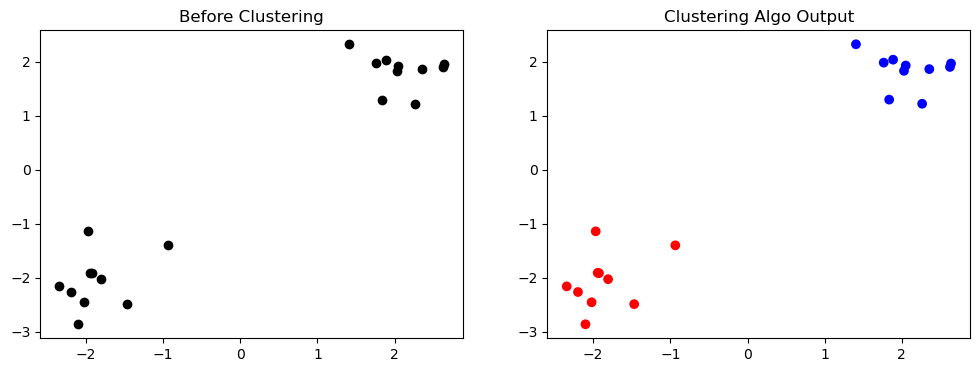

In [46]:
# Visualising the original data, and the identified clusters.
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.scatter(dummy_data[:,0], dummy_data[:, 1], facecolor='black'); ax1.set_title('Before Clustering');
ax2.scatter(dummy_data[:,0], dummy_data[:, 1], facecolor=fc); ax2.set_title('Clustering Algo Output');

There are many different clustering algorithms. You may have heard of K-means, a very popular one, before. The one we are going to use here is very similar to it. It is known as **agglomerative hierarchical clustering**. Let's take a look at how it works first.

<img src="../figs/clust_agglomerative_hierarchical.png" style="width: 600px;"/>

### How Does The Clustering Algorithm Work?

#### Dissimilarity Measures Between Individual Observations

As we mentioned earlier, cluster analysis tries to identify groups such that those within a group are "similar" to one another. In order to proceed, we need to formalise this idea of similarity/dissimilarity. 

Most of the time, we have $N$ observations $x_1, x_2, \dots, x_N$ and we wish to group them into $K$ clusters. Each observation is typically a vector of $p$ observed values, so we may write $x_i = (x_{i1}, x_{i2}, \dots, x_{ip})$ for instance. Referring back to our CD example, we had $N=23570$ customers, and we had engineered $p=3$ features: recency, frequency and monetary value.

Most clustering algorithms require a dissimilarity matrix as input, so we need a function that can measure **pairwise dissimilarity**. One of the most common choices is the Euclidean distance (or rather the $L_2$-norm) between $x_i$ and $x_j$:
\begin{equation*}
d(x_i,\;x_j) = \bigg\{\sum_{s=1}^p (x_{is} - x_{js})^2\bigg\}^{1/2}
\end{equation*}

Another common choice is the $L_1$-norm:
\begin{equation*}
d(x_i,\;x_j) = \sum_{s=1}^p |x_{is} - x_{js}|
\end{equation*}

#### Dissimilarity Measures Between Clusters or Groups

For hierarchical clustering, we need to build on this choice of pairwise dissimilarity to obtain a measure of dissimilarity between groups. In other words, suppose we have two groups of points $G$ and $H$, with $N_G$ and $N_H$ points within them respectively. We wish to use the pairwise dissimilarity between points in $G$ and $H$, to compute a dissimilarity between $G$ and $H$. We call this the **linkage method**, and there are several options for this too:

1. Single linkage takes the intergroup dissimilarity to be that of the closest (least dissimilar) pair.
\begin{equation*}
d_S(G,H) = \min_{i \in G, j \in H} d(x_i,\, x_j)
\end{equation*}
2. Complete linkage takes the intergroup dissimilarity to be that of the furthest (most dissimilar) pair.
\begin{equation*}
d_C(G,H) = \max_{i \in G, j \in H} d(x_i,\, x_j)
\end{equation*}
3. Average linkage utilises the average of all pairwise dissimilarities between the groups:
\begin{equation*}
d_A(G,H) = \frac{1}{N_G N_H} \sum_{i \in G} \sum_{j \in H} d(x_i,x_j)
\end{equation*}
4. Ward linkage uses a more complicated distance to minimise the variance within groups. It usually returns more compact clusters than the others. Suppose that group $G$ was formed by merging groups $G_1$ and $G_2$. Then the Ward distance between groups is 
\begin{equation*}
d_W(G,H) = \left\{\frac{|H| + |G_1|}{N_G + N_H}d_W(H,G_1)^2 + \frac{|H| + |G_2|}{N_G + N_H}d_W(H,G_2)^2 + \frac{|H|}{N_G +N_H}d_W(G_1,G_2)^2\right\}^{1/2}
\end{equation*}

The choice of linkage can affect the final clusters we obtain, so it is important to choose carefully based on the subject matter.

<img src="../figs/clust_linkage_mtds.png" style="width: 600px;"/>

#### Agglomerative Hierarchical Clustering Algorithm

The output of the algorithm is a hierarchical representation of the data, where clusters at each level of the 
hierarchy are created by merging clusters at the next lower level. At the lowest level, each cluster contains a single observation. At the highest level there is only one cluster containing all of the data.

Starting at the bottom (with $N$ clusters of singletons), we recursively merge a selected pair of
clusters into a single cluster. This produces a grouping at the next higher level with one less cluster. The pair chosen for merging consist of the two groups with the smallest intergroup dissimilarity. 

As you can tell, this algorithm does not require the number of clusters as an input. The final number of clusters can be based on a visualisation of this hierarchy of clusterings, through a dendrogram.

In [47]:
X = np.array([[.25, .7], [.3, .8], [.7, .6]])
fc_dict={'Stage 0': ['red', 'blue', 'green'], 'Stage 1': ['red', 'red', 'green'], 
        'Stage 2': ['red']*3}

In [48]:
X

array([[0.25, 0.7 ],
       [0.3 , 0.8 ],
       [0.7 , 0.6 ]])

In [49]:
from scipy.spatial.distance import pdist, squareform

In [50]:
pdist(X)

array([0.1118034 , 0.46097722, 0.4472136 ])

In [51]:
squareform(pdist(X))

array([[0.        , 0.1118034 , 0.46097722],
       [0.1118034 , 0.        , 0.4472136 ],
       [0.46097722, 0.4472136 , 0.        ]])

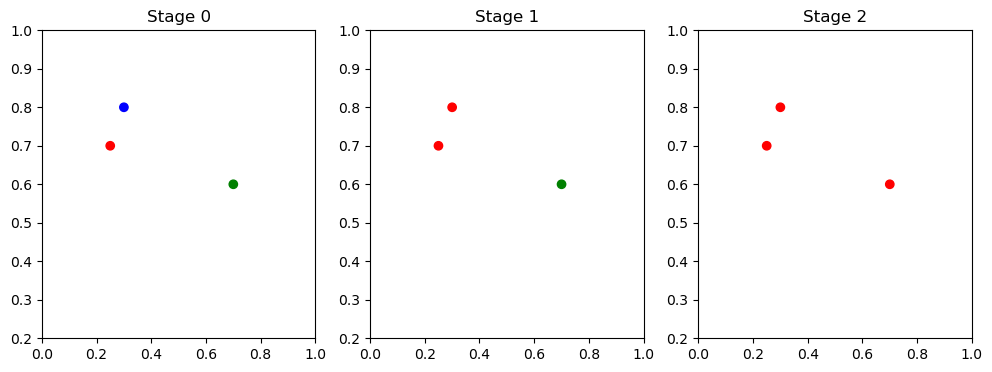

In [52]:
plt.figure(figsize=(12,4))
for x,y in enumerate(fc_dict.items()):
    plt.subplot(1,3,x+1)
    plt.scatter(X[:,0], X[:,1], facecolor=y[1]);
    plt.ylim(0.2,1); plt.xlim(0,1)
    #plt.grid(); 
    plt.title(y[0])

As we can see the number of clusters changed from 3 to 2 and then to 1. Here is how we can visualise the hierarchy:

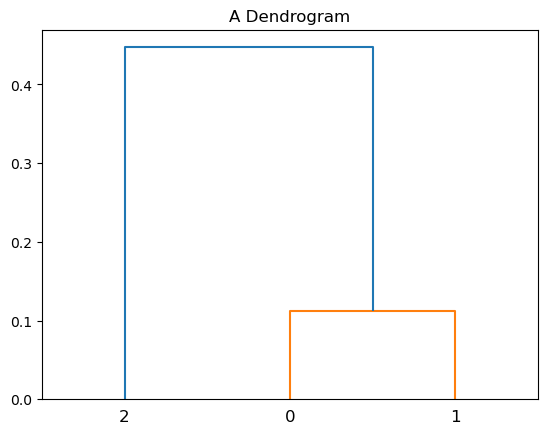

In [53]:
lm0 = hierarchy.linkage(X)
hierarchy.dendrogram(lm0, p=2)
plt.title('A Dendrogram');

In [54]:
lm0

array([[0.       , 1.       , 0.1118034, 2.       ],
       [2.       , 3.       , 0.4472136, 3.       ]])

The dendrogram shows that points with index 0 and 1 (the closest two points) merge at a small vertical distance (height of orange lines), but the group containing them merges with point 2 at a much higher vertical distance (blue line on the left). This shows that points 0 and 1 are less dissimilar to one another than they are (as a group) to point 2. In other words, the *height of each node is proportional to the value of the intergroup dissimilarity between its two child nodes*.

### Back to CDNOW Customers

Now that we know a technique for segmenting data, let us apply it to our customers. Before we do so, we shall scale the dataset so that each of the three columns R,F and M has 0 mean and variance 1. This prevents a particular column from dominating the results because it is orders of magnitude larger than the others. We shall carry out this scaling by subtracting the column mean and then dividing by the column standard deviation for each observation.

In [55]:
cd3.head()

,r,f,m
cid,,,
1,-77,1,11.77
2,-76,1,89.00
3,-4,6,156.46
4,-28,4,100.50
5,-25,11,385.61


In [56]:
X = cd3.to_numpy()
X_scaled = ((X - X.mean(axis=0))/X.std(axis=0))

In [57]:
lm1 = hierarchy.linkage(X_scaled, method='ward')

In [58]:
lm1

array([[0.00000000e+00, 1.38000000e+02, 0.00000000e+00, 2.00000000e+00],
       [5.00000000e+00, 5.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.30000000e+01, 6.16000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [4.71320000e+04, 4.71330000e+04, 1.11269108e+02, 5.21000000e+02],
       [4.71350000e+04, 4.71360000e+04, 1.74074446e+02, 8.99000000e+03],
       [4.71260000e+04, 4.71370000e+04, 2.44966385e+02, 2.35700000e+04]])

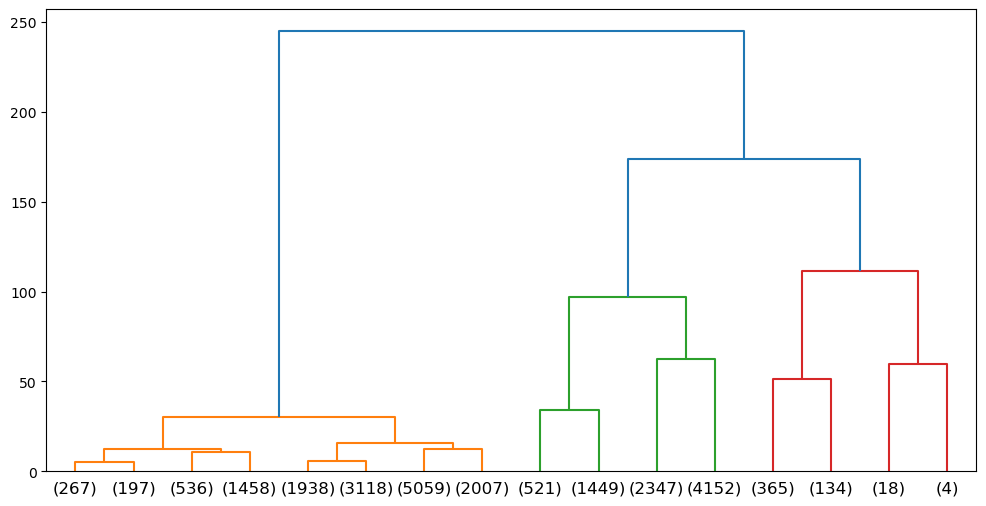

In [59]:
plt.figure(figsize=(12,6))
hierarchy.dendrogram(lm1, p=3, truncate_mode='level');

It seems reasonable that we can split the customers into three groups. Can we categorise these groups in some way?

In [60]:
out = hierarchy.cut_tree(lm1, n_clusters=3).ravel()
cd3['groups'] = out

In [61]:
cd3.groupby('groups').agg([np.median, lambda x: np.quantile(x, .75) - np.quantile(x, .25)])
# cd3.groupby('groups').describe()

r                 f                  m           
       median <lambda_0> median <lambda_0>  median <lambda_0>
groups                                                       
0       -71.0        6.0    1.0        0.0   26.10      30.21
1       -20.0       29.0    4.0        4.0  118.92     154.62
2        -3.0        7.0   16.0        7.0  817.17     613.08

In [62]:
cd3.groups.value_counts()

0    14580
1     8469
2      521
Name: groups, dtype: int64

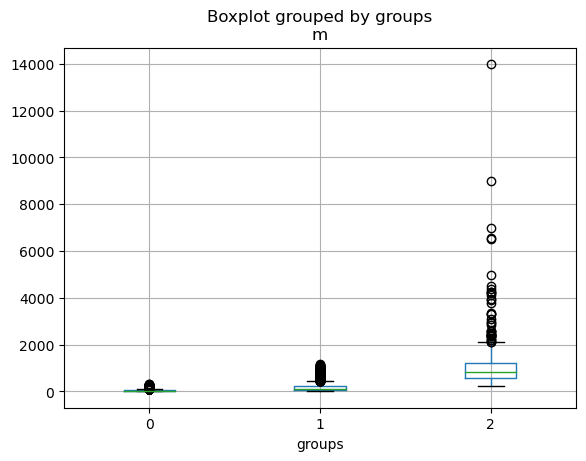

In [63]:
cd3.boxplot('m', by="groups");

### Determining the optimal number of clusters

We used 3 clusters, but can we come up with a more formal method of determining the optimal number of clusters?

The Silhouette coefficient summarises the within similarity to the between similarity using the following formula:

\begin{equation*}
S = \frac{b-a}{\max(a,b)}
\end{equation*}

where $a$ is the average distance between an observation and all other observations in the same cluster and $b$ is the average distance between an observation and all other observations in the *next nearest cluster*. This coefficient takes values between -1 and 1, with values closer to 1 indicating a more optimal clustering.

In [64]:
clust.compute_silhouette_scores(lm1, X_scaled, [2,3,4,5,6])

Computing groupings for k=2
Computing score for k=2
Computing groupings for k=3
Computing score for k=3
Computing groupings for k=4
Computing score for k=4
Computing groupings for k=5
Computing score for k=5
Computing groupings for k=6
Computing score for k=6


[0.6101493531750831,
 0.6400746375538853,
 0.6401818881842296,
 0.621210571182339,
 0.583675324907431]

---
<a id='mba'></a>
## Market Basket Analysis
<a href=#top>(back to top)</a>

Association rules analysis is a very popular tool for mining commercial databases. It is applicable when you have transaction-level data. In other words, the observations in your data consist of sales transactions - items purchased by customers at a physical or online store. The goal of an association rules analysis is to identify items that are frequently bought together. This information can be very useful in 

  * stocking shelves at the physical store, or even at the warehouse,
  * cross-marketing in sales promotions, and 
  * designing catalogues for mail-in promotions or advertisements.
  
### Apriori Algorithm

Customer databases can be very huge. It is computationally infeasible to compute the proportion of all $2^N$ types of items. The apriori algorithm gets around this using this clever trick:

> If an itemset is infrequent, any itemset that contains it is also infrequent.

For instance, if I know that `{caviar, eggs}` are bought very rarely, then `{caviar, eggs, wine}` will be even more rarely purchased.

### What are Association Rules?

Let $X$ and $Y$ be itemsets. They denote possible "baskets" of items that could be purchased together. Suppose that there have been $N$ transactions in a database. Then we define the support of an itemset to be 

\begin{equation*}
\text{Support}(X) = \frac{\text{no. of transactions that contain $X$}}{N}
\end{equation*}

The goal of this section is to identify *interesting* rules of the form:
\begin{equation*}
X \Rightarrow Y
\end{equation*}
which we interpret as: if a customer purchases itemset $X$ (the *antecedent*), then he will purchase itemset $Y$ (the *consequent*). Rules are not certainties - that is why we need to compute several metrics on any postulated rule before we can act on it.

### Definitions

1. The support of a rule $X \Rightarrow Y$ is defined to be 

\begin{equation*}
\text{Support}(X \Rightarrow Y) = \frac{\text{no. of transactions that contain $X$ and $Y$}}{N} = P(X \cup Y)
\end{equation*}

2. The confidence of a rule $X \Rightarrow Y$ is defined to be 

\begin{equation*}
\text{Confidence}(X \Rightarrow Y) = \frac{\text{no. of transactions that contain $X$ and $Y$}}{\text{no. of transactions that contain $X$}} = P( Y | X)
\end{equation*}

The confidence of a rule will be a value between 0 and 1. It gives us an indication of the chance that a customer will add on to his current purchase.

3. The lift of a rule $X \Rightarrow Y$ is defined to be 

\begin{equation*}
\text{Lift}(X \Rightarrow Y) = \frac{\text{Confidence}(X \Rightarrow Y)}{\text{Support}(Y)} = P( Y | X) / P(Y)
\end{equation*}

Note that the lift of $X \Rightarrow Y$ is the same as the lift of $Y \Rightarrow X$. The lift of a rule is a value between 0 and $\infty$. A value of 1 denotes that there is no value in promoting $Y$ to a customer who intends to purchase $X$. Values greater than 1 indicate a useful rule for cross-promotion.

4. The leverage of a rule $X \Rightarrow Y$ is defined to be 

\begin{equation*}
\text{Leverage}(X \Rightarrow Y) = \text{Support}(X \Rightarrow Y) - \text{Support}(Y)\text{Support}(X)
\end{equation*}

This will be a value between -1 and 1. It gives an indication of association between the products. If leverage is positive, it means that customers were more likely to buy these two itemsets together, compared to the chance of buying them if these two itemsets were independent.

5. The conviction of a rule $X \Rightarrow Y$ is defined to be 

\begin{equation*}
\text{Conviction}(X \Rightarrow Y) = \frac{1 - \text{Support}(Y)}{1 - \text{Confidence}(X \Rightarrow Y)} =
\frac{P(Y^c)}{P(Y^c | X)}
\end{equation*}

A value more than 1 indicates that $Y$ is more likely bought with $X$ than without. Conviction was conceived of to replace lift, which is non-directional.

Let's consider a simple example before applying these ideas to a larger dataset. Consider the following table of transactions:

| transaction | itemset                 |
|-------------|-------------------------|
| 1           | butter, jelly           |
| 2           | butter, jelly           |
| 3           | p.butter, butter        |
| 4           | p.butter, butter, jelly |
| 5           | p.butter                |

Now let us focus on a particular rule: $\text{butter} \Rightarrow \text{jelly}$.

1. The support of the rule is 3/5.
2. The confidence of the rule is 3/4.
3. The lift of the rule is .75/(3/5) = 1.25
4. The leverage of the rule is .6 - .8(.6) = .12
5. The conviction of the rule is .4/(1-.75) = 1.6

The dataset that we shall consider next consists of gifts purchased from an online retailer. The original dataset was obtained here: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II, but the version we have here is heavily cleaned. Initially, there were 3843 different types of items. They were re-categorised, with those that occurred too often being dropped. The first column is an invoice number, indicating which items were bought together.

In [65]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
all_trans2 = pd.read_csv('../data/online_gift_trans.csv')

In [ ]:
all_trans2.head(n=10)

In [ ]:
all_trans2.desc2.unique()

In [ ]:
trans_list = all_trans2.groupby('InvoiceNo').apply(lambda x: x.desc2.to_list()).to_list()

In [ ]:
trans_list[0:10]

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(trans_list).transform(trans_list, sparse=True)
df2 = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

In [ ]:
df2.head()

The input to the apriori algorithm requires a boolean matrix with one row for each transaction (invoice), and one column for each item. As we can see, we have 34 categories of items now.

In [ ]:
ap_out = apriori(df2, min_support=0.01, use_colnames=True, max_len=4, verbose=True)

We can inspect the frequent itemsets since it is just a pandas DataFrame.

In [ ]:
# ap_out.head()
ap_out[ap_out.itemsets <= {'BUNTING', 'CLOCKS'}]
#ap_out[ap_out['itemsets'] >= {'LIGHTS', 'TOYS'}]

In [ ]:
ap_out.sort_values('support', ascending=False).head()

Now, we proceed to generate association rules with a minimum confidence of 0.5, and try to answer a few questions of interest:

1. What is an interesting rule that I can use?
2. I have an excess of notebooks - what can I pair them with to sell them off?
3. A customer has tissues and towels in his shopping cart - what should I recommend to him?

In [ ]:
ar = association_rules(ap_out, metric='confidence', min_threshold=0.5)

In [ ]:
ar[(ar.confidence > 0.7) & (ar.antecedents.apply(len) <= 2)].sort_values(by='lift', ascending =False)

Regarding question 1, it looks like I can place or stock SIGNS close to key chains, bathroom accessories and wallets since the lift, leverage and conviction are all high.

In [ ]:
ar[(ar.consequents == {'NOTEBOOKS'}) & (ar.antecedents.apply(len) <= 2)].sort_values(by='conviction', ascending=False).head()

The support for key chains and stationery is the highest in the above table, and the conviction is high. So I might consider pairing notebooks with those items. I could also consider pairing it with magnets and baskets.

In [ ]:
ar[ar.antecedents == {'TOWELS', 'TISSUES'}]

I should recommend stationery to him.

### Some caveats when using Market Basket Analysis

Market basket analysis is taught in many books, and there are many papers on the algorithms to derive the association rules from huge databases. However, you will find comparatively less papers and articles on the success from using Market Basket Analysis (an exception is the Target story).

There could be a reason for this. Suppose that a store finds that two brands of soft drink (A and B) are often bought together. Hence, they decide to run a promotion on brand A, hoping that it would trigger an increase in the sales of brand B. Instead, the sales of brand B dropped dramatically!!?

This happens when the two products have a substitute relationship instead of a complementary one. When customers see a price drop in one of them, they switch to it, at the expense of the one whose price did not drop.

What can we do to avoid situations like this?

<a id='ref'></a>
### References and Summary
<a href=#top>(back to top)</a>

1. [CDNOW dataset download](https://www.brucehardie.com/datasets/) (also available on Canvas)
2. [An Introduction to Statistical Learning](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) Chapter 12 of this book covers hierarchical clustering in more detail, along with other clustering techniques. 
3. *Drilling down: turning customer data into profits with a spreadsheet*, by Jim Novo. This book covers several methods in customer analytics, and shows you how to use them on a spreadsheet. It is available at our library.